In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ---- CONFIG: set your file path and column names ----
CSV_PATH = "/content/drive/MyDrive/sentiment_outputs_final2/review_level_sentiment.csv"
COL_SENT = "sentiment_score_w"
COL_BRAND = "brand_name"
COL_TIME  = "submission_time"
INTENSITY_TH = 0.6    # |sentiment| >= threshold → strong emotion
TOP_N_BRANDS = 10

Data loaded successfully!
Shape: (16800, 6)
Columns: ['review_seq_id', 'sentiment_score_w', 'rating', 'brand_name', 'submission_time', 'sentiment_label_w']


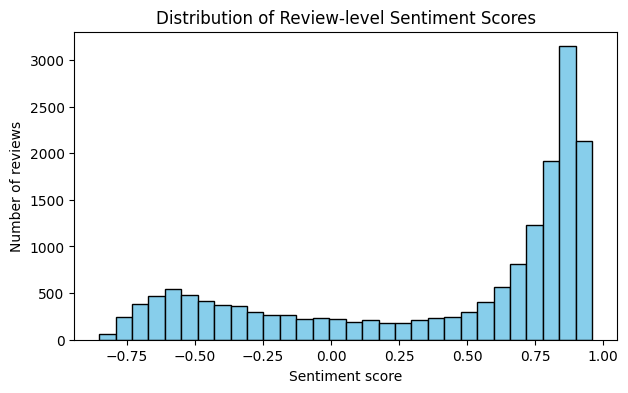


=== Overall sentiment summary ===
count    16800.000
mean         0.406
std          0.569
min         -0.853
5%          -0.652
25%         -0.121
50%          0.720
75%          0.863
95%          0.921
max          0.960
Name: sentiment_score_w, dtype: float64


In [3]:
# 1) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2) Load data
try:
    df = pd.read_csv(CSV_PATH, parse_dates=[COL_TIME])
except Exception:
    df = pd.read_csv(CSV_PATH)

# Quick check
print("Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Drop missing sentiment values
df = df.dropna(subset=[COL_SENT]).copy()

# 3) Overall sentiment distribution
plt.figure(figsize=(7,4))
plt.hist(df[COL_SENT], bins=30, edgecolor="black", color="skyblue")
plt.title("Distribution of Review-level Sentiment Scores")
plt.xlabel("Sentiment score")
plt.ylabel("Number of reviews")
plt.show()

print("\n=== Overall sentiment summary ===")
print(df[COL_SENT].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(3))

In [4]:
# 4) Polarity share (positive / neutral / negative)
def label_polarity(x, eps=0.05):
    if x >  eps: return "positive"
    if x < -eps: return "negative"
    return "neutral"

polarity_counts = df[COL_SENT].apply(label_polarity).value_counts(normalize=True)
print("\n=== Polarity distribution ===")
for label, share in polarity_counts.items():
    print(f"{label.capitalize():<10}: {share*100:.1f}%")


=== Polarity distribution ===
Positive  : 71.2%
Negative  : 26.6%
Neutral   : 2.1%


In [5]:
INTENSITY_TH = 0.6
strong_share = (df[COL_SENT].abs() >= INTENSITY_TH).mean()
print(strong_share)

0.6576785714285714



=== Top brands by average sentiment ===


,avg,var,n
brand_name,,,
Dr. Dennis Gross Skincare,0.475,0.292,1200
belif,0.474,0.270,1600
Farmacy,0.461,0.332,2000


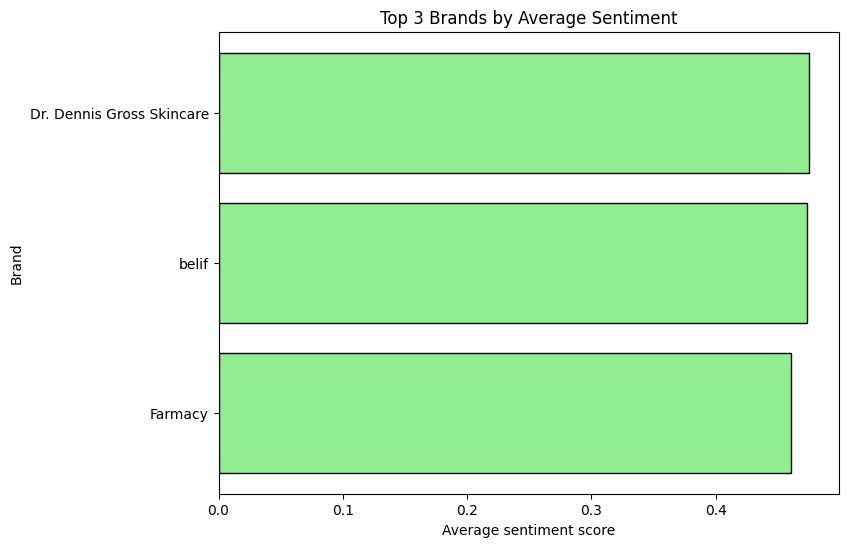

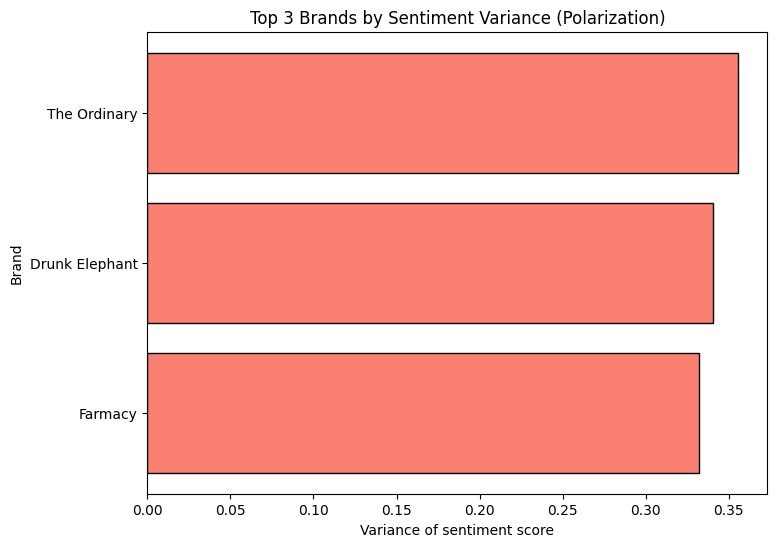

In [6]:
# 6) Brand-level sentiment stats (if brand column exists)
TOP_N_BRANDS = 3

if COL_BRAND in df.columns:
    brand_stats = (
        df.groupby(COL_BRAND)[COL_SENT]
          .agg(avg="mean", var="var", n="count")
          .sort_values("avg", ascending=False)
    )

    print("\n=== Top brands by average sentiment ===")
    display(brand_stats.head(TOP_N_BRANDS).round(3))

    # Bar plot of top-N brands by average sentiment
    top_avg = brand_stats.head(TOP_N_BRANDS).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(top_avg.index, top_avg["avg"], color="lightgreen", edgecolor="black")
    plt.title(f"Top {TOP_N_BRANDS} Brands by Average Sentiment")
    plt.xlabel("Average sentiment score")
    plt.ylabel("Brand")
    plt.show()

    # Optional: brands with highest variance (polarized opinions)
    top_var = brand_stats.sort_values("var", ascending=False).head(TOP_N_BRANDS).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(top_var.index, top_var["var"], color="salmon", edgecolor="black")
    plt.title(f"Top {TOP_N_BRANDS} Brands by Sentiment Variance (Polarization)")
    plt.xlabel("Variance of sentiment score")
    plt.ylabel("Brand")
    plt.show()
